# Purpose


The purpose of this notebook is to investigate the effectiveness of the deconfounder algorithm (Blei et. al, 2018) in adjusting for unobserved confounding. We use a simulated mode choice data where travel distance linearly confounds both travel time and travel cost. We then mask the travel distance data and treat it as an unobserved variable. 

We estimate three models:
- Model 1: A multinomial logit with the correct original specification, EXCEPT we ommit the travel distance variable in the specification without trying to adjust for it. 
- Model 2: We use the deconfounder algorithm to try to recover the confounder (travel distance). In this method, we use all the variables in each mode's utility to recover that mode's confounder.
- Model 3: We use the deconfounder algorithm to try to recover the confounder (travel distance), but this time, we only use travel time and cost in the factor model, instead of all the variables in the utility specification of each mode. 

We compare the estimates of the coefficients on travel time and cost to the true estimates used in the simulation. The main findings of this exercise are the following:
- Using the true variables believed to be confounded (i.e. method 3 where only travel time and cost are used to recover the confounder) leads to a better recovery of the true confounder. This suggests that it may be better to run the deconfounder algorithm based on a hypothesized causal graph, rather than just running it on all the observed covariates. 
- Similar to what we found in the investigating_decounfounder notebook, the effectiveness of the deconfounder algorithm is very sensitive to small deviations in the recovered confounder. Although method 3 returns a relatively good fit of the true confounder, the adjusted coefficients on travel time and cost do not exhibit any reduction in the bias resulting from ommitting the true confounder, and the coefficients on the recovered confounder are highly insignificant. This raises questions about the usefulness of the deconfounder algorithm in practice.

# Import needed libraries

In [1]:
# Built-in modules
import os
from collections import OrderedDict
from functools import reduce

# Third party modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit as cm

# Local modules
from factor_models import *


## Useful function

In [8]:
def specifications(mnl_specification, num_modes):
    newDict= dict()

    for i in range(1,num_modes+1):
        variables = []
        # Iterate over all the items in dictionary and filter items which has even keys
        for (key, value) in mnl_specification.items():
           # Check if key is even then add pair to new dictionary
    



            if any(isinstance(sub, list) for sub in value):
                for sub in value:
                    if isinstance(sub, list):
                        if (i in sub): 
                            variables.append(key)
                            
                    else:
                        if i == sub:
                            variables.append(key)

            else:
                if i in value:
        #             print(variables)

                    variables.append(key)

        newDict[i] = variables

    return newDict

## Analysis

In [2]:
PATH = '../../data/raw/'
file_name = 'simulated_long_format_bike_data.csv'

In [3]:
data = pd.read_csv(PATH+file_name)
data = data.drop('Unnamed: 0', axis = 1)
data.columns

Index(['observation_id', 'mode_id', 'sim_choice', 'num_kids', 'household_size',
       'num_cars', 'num_licensed_drivers', 'cross_bay', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance',
       'cars_per_licensed_drivers', 'cost_per_distance', 'intercept'],
      dtype='object')

In [4]:
X_columns = ['total_travel_time',
       'total_travel_cost', 'total_travel_distance', 
             'cross_bay', 'household_size', 'num_kids', 
              'cars_per_licensed_drivers', 
             'gender'
             
            ]

y_column = data['mode_id']

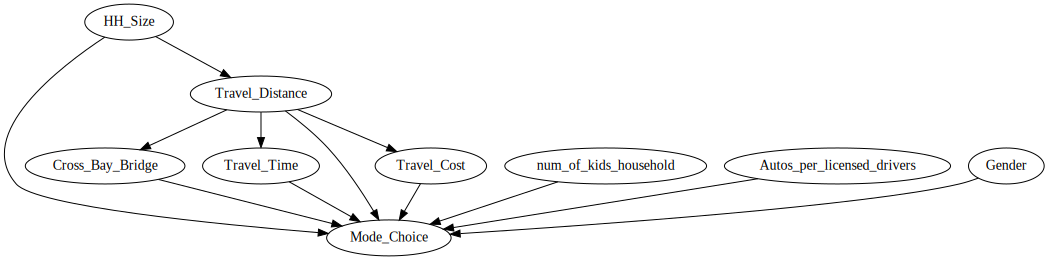

In [5]:
## Specify the true causal graph used in the simulation of the choices

causal_graph = CausalGraphicalModel(
    nodes=["Travel_Time", "Travel_Distance", "Travel_Cost", "Cross_Bay_Bridge", "HH_Size", "num_of_kids_household",
          "Autos_per_licensed_drivers", "Gender", "Mode_Choice"],
    edges=[
        ("Travel_Time", "Mode_Choice"), 
        ("Travel_Distance", "Mode_Choice"), 
        ("Travel_Cost", "Mode_Choice"), 
        ("Cross_Bay_Bridge", "Mode_Choice"), 
        ("HH_Size", "Mode_Choice"), 
        ("num_of_kids_household", "Mode_Choice"), 
        ("Autos_per_licensed_drivers", "Mode_Choice"), 
        ("Gender", "Mode_Choice"), 
        
        
        ("Travel_Distance", "Travel_Time"), 
        ("Travel_Distance", "Travel_Cost"), 
        ("Travel_Distance", "Cross_Bay_Bridge"), 
        ("HH_Size", "Travel_Distance"), 

        
        
#         ("Travel_Time", "Mode_Choice"), 
#         ("Travel_Time", "Mode_Choice"), 

        
        
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
causal_graph.draw()

# MNL specification

In [6]:
## Below is the specification of the true model used in the simulation of the choices

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [1, 2, 3, [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (Drive Alone)',
                                  'Travel Time, units:min (SharedRide-2)',
                                  'Travel Time, units:min (SharedRide-3+)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [1, 2, 3, [4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (Drive Alone)',
                                  'Travel Cost, units:$ (SharedRide-2)',
                                  'Travel Cost, units:$ (SharedRide-3+)',
                                  'Travel Cost, units:$ (All Transit Modes)']

# mnl_specification["cost_per_distance"] = [1, 2, 3]
# mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
#                                   "Travel Cost per Distance, units:$/mi (SharedRide-2)",
#                                   "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [1, 2, 3, 7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Drive Alone)',
                                      'Travel Distance, units:mi (SharedRide-2)',
                                      'Travel Distance, units:mi (SharedRide-3+)',
                                      'Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Recovering the confounder: The deconfounder algorithm

## First approach: using all the variables in the factor model

Using this approach, we use all the variables in each mode's utility specification to recover the confounder, in line with Blei et al.'s approach in their paper.

In [10]:
## Return the variables of each utility specification

spec_dic = specifications(mnl_specification=mnl_specification, num_modes=8)
spec_dic

{1: ['total_travel_time',
  'total_travel_cost',
  'cars_per_licensed_drivers',
  'total_travel_distance'],
 2: ['intercept',
  'total_travel_time',
  'total_travel_cost',
  'cars_per_licensed_drivers',
  'total_travel_distance',
  'cross_bay',
  'household_size',
  'num_kids'],
 3: ['intercept',
  'total_travel_time',
  'total_travel_cost',
  'cars_per_licensed_drivers',
  'total_travel_distance',
  'cross_bay',
  'household_size',
  'num_kids'],
 4: ['intercept', 'total_travel_time', 'total_travel_cost'],
 5: ['intercept', 'total_travel_time', 'total_travel_cost'],
 6: ['intercept', 'total_travel_time', 'total_travel_cost'],
 7: ['intercept', 'total_travel_distance'],
 8: ['intercept', 'total_travel_distance']}

Analysis for mode:  1
-------------------------------------------------------------------------------------------
1 ['total_travel_time', 'total_travel_cost', 'cars_per_licensed_drivers']



/Users/hassanobeid/UC_Berkeley/PhD/Causality_Research/Github/tr_b_causal_2020/notebooks/working/factor_models.py:120: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  log_joint = ed.make_log_joint_fn(ppca_model)




Inferred axes:
[[1.0977817  1.0978527  0.12275438]]
Standard Deviation:
[[0.00799574 0.00553362 0.00515038]]


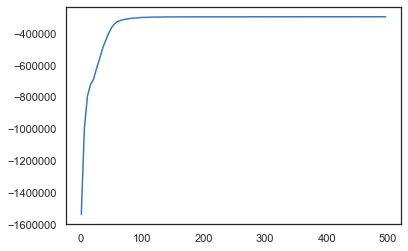

Analysis for mode:  2
-------------------------------------------------------------------------------------------
2 ['total_travel_time', 'total_travel_cost', 'cars_per_licensed_drivers', 'cross_bay', 'household_size', 'num_kids']
Inferred axes:
[[ 1.1891068   1.1899593  -0.03712635  0.20784217  0.03731374  0.08648779]]
Standard Deviation:
[[0.0053368  0.00544814 0.00564327 0.00546307 0.00445172 0.00618899]]


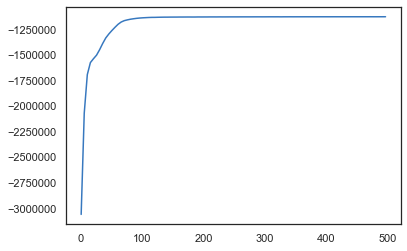

Analysis for mode:  3
-------------------------------------------------------------------------------------------
3 ['total_travel_time', 'total_travel_cost', 'cars_per_licensed_drivers', 'cross_bay', 'household_size', 'num_kids']
Inferred axes:
[[ 1.1478888   1.1470537   0.17280054  0.05781162  0.04793473 -0.07809858]]
Standard Deviation:
[[0.00867586 0.006379   0.00573987 0.00574165 0.00627476 0.00552721]]


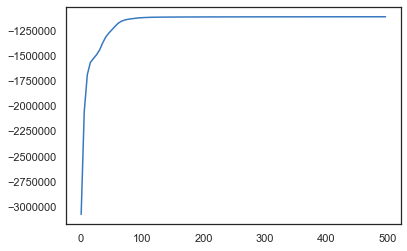

Analysis for mode:  4
-------------------------------------------------------------------------------------------
4 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[2.559579  3.0805016]]
Standard Deviation:
[[0.01492301 0.0158586 ]]


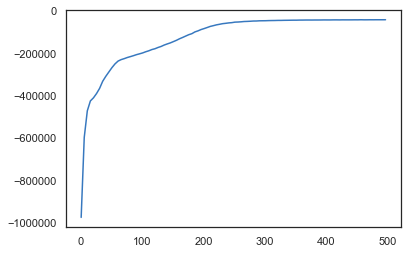

Analysis for mode:  5
-------------------------------------------------------------------------------------------
5 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[0.8909465 0.9005865]]
Standard Deviation:
[[0.00589359 0.00755761]]


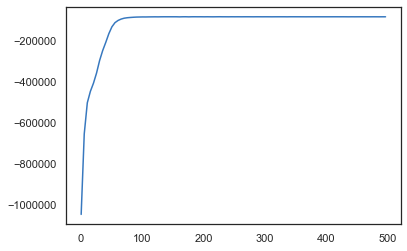

Analysis for mode:  6
-------------------------------------------------------------------------------------------
6 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[0.88016903 0.8809115 ]]
Standard Deviation:
[[0.00484792 0.00581999]]


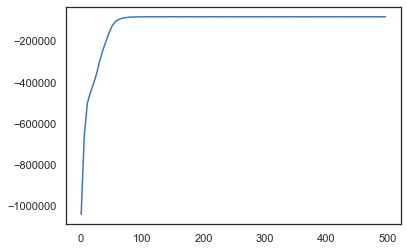

Analysis for mode:  7
-------------------------------------------------------------------------------------------
7 []
Inferred axes:
[]
Standard Deviation:
[]


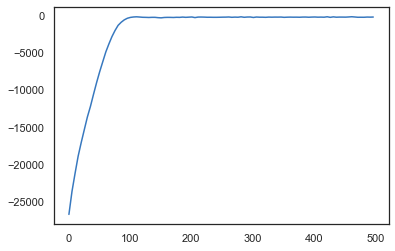

Analysis for mode:  8
-------------------------------------------------------------------------------------------
8 []
Inferred axes:
[]
Standard Deviation:
[]


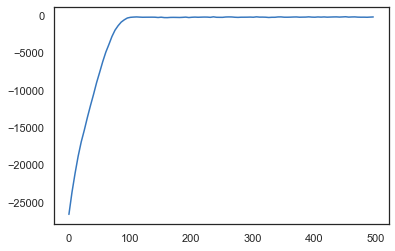

In [12]:
confounder_vectors = []
holdout_dfs = []
masks_df = []
rows_df =[]
latent_dim = 1
for i in data['mode_id'].unique():

    data_mode_i = data[data['mode_id']==i]
    # standardize the data for PPCA
    print("Analysis for mode: ", i)
    print("-------------------------------------------------------------------------------------------")
    X_columns = spec_dic[i]
    
    if 'intercept' in X_columns:
        X_columns.remove('intercept')
        
    if 'total_travel_distance' in X_columns:
        X_columns.remove('total_travel_distance')
        
    print(i, X_columns)
    
    X = np.array((data_mode_i[X_columns] - data_mode_i[X_columns].mean())/data_mode_i[X_columns].std())
    
    confounders, holdouts, holdoutmasks, holdoutrow= confounder_ppca(holdout_portion=0.2, X=X, latent_dim=latent_dim)

    confounder_vectors.append(confounders)
    holdout_dfs.append(holdouts)
    masks_df.append(holdoutmasks)
    rows_df.append(holdoutrow)

## Second approach: using only the confounded variables in the factor model
Using this approach, we only run the deconfounder's factor model on travel_time and travel_cost, which are the only variables confounded with travel_distance in our simulation

Inferred axes:
[[1.0148872 1.0119478]]
Standard Deviation:
[[0.00600001 0.00627595]]


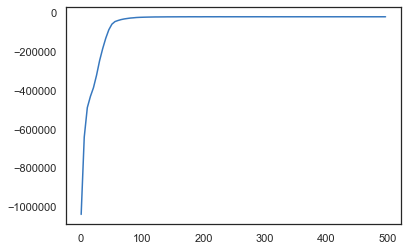

Inferred axes:
[[1.0047468  0.99433863]]
Standard Deviation:
[[0.00447973 0.00776866]]


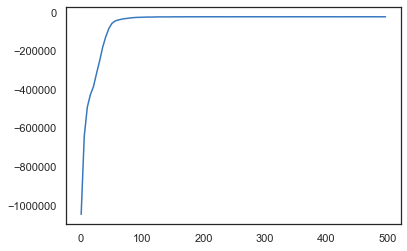

Inferred axes:
[[1.0213395 1.0193049]]
Standard Deviation:
[[0.00578112 0.00653108]]


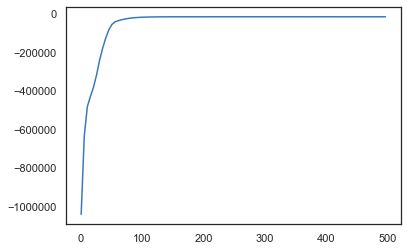

In [13]:
confounded_variables = ['total_travel_time', 'total_travel_cost']
X_DA = (data[data['mode_id']==1][confounded_variables] - 
        data[data['mode_id']==1][xs].mean())/data[data['mode_id']==1][xs].std()

X_SR2 = ((data[data['mode_id']==2][confounded_variables] - 
         data[data['mode_id']==2][confounded_variables].mean())
         /data[data['mode_id']==2][confounded_variables].std())
X_SR3 = ((data[data['mode_id']==3][confounded_variables] - 
         data[data['mode_id']==3][confounded_variables].mean())
         /data[data['mode_id']==3][confounded_variables].std())

(confounders_DA, holdouts_DA, 
 holdoutmasks_DA, holdoutrow_DA)= confounder_ppca(holdout_portion=0.2, 
                                       X=X_DA, latent_dim=latent_dim)

(confounders_SR2, holdouts_SR2, 
 holdoutmasks_SR2, holdoutrow_SR2)= confounder_ppca(holdout_portion=0.2, 
                                       X=X_SR2, latent_dim=latent_dim)

(confounders_SR3, holdouts_SR3, 
 holdoutmasks_SR3, holdoutrow_SR3)= confounder_ppca(holdout_portion=0.2, 
                                       X=X_SR3, latent_dim=latent_dim)





## Adding confounders to original DF

In [1]:
def add_confounders_to_df(data, confounder_vectors):
    for i in data['mode_id'].unique():
    
#     print(len(data.loc[data['mode_id']==i, col_name]), len(confounder_vectors[int(i-1)][2]) )
    
        col_name = 'confounder_for_mode_' + str(int(i))
        data.loc[data['mode_id']==i, col_name] = confounder_vectors[int(i-1)][2]
        data[col_name] = data[col_name].fillna(0)

    data['confounder_all'] = data[['confounder_for_mode_1','confounder_for_mode_2','confounder_for_mode_3',
                                  'confounder_for_mode_4', 'confounder_for_mode_5', 'confounder_for_mode_6',
                                  'confounder_for_mode_7', 'confounder_for_mode_8']].sum(axis=1)

In [14]:
for i in data['mode_id'].unique():
    
#     print(len(data.loc[data['mode_id']==i, col_name]), len(confounder_vectors[int(i-1)][2]) )
    
    col_name = 'confounder_for_mode_' + str(int(i))
    data.loc[data['mode_id']==i, col_name] = confounder_vectors[int(i-1)][2]
    data[col_name] = data[col_name].fillna(0)
    
data['confounder_all'] = data[['confounder_for_mode_1','confounder_for_mode_2','confounder_for_mode_3',
                              'confounder_for_mode_4', 'confounder_for_mode_5', 'confounder_for_mode_6',
                              'confounder_for_mode_7', 'confounder_for_mode_8']].sum(axis=1)


data.loc[data['mode_id']==1, 'confounder_da'] = confounders_DA[2]
data['confounder_da'] = data['confounder_da'].fillna(0)

data.loc[data['mode_id']==2, 'confounder_sr2'] = confounders_SR2[2]
data['confounder_sr2'] = data['confounder_sr2'].fillna(0)

data.loc[data['mode_id']==3, 'confounder_sr3'] = confounders_SR3[2]
data['confounder_sr3'] = data['confounder_sr3'].fillna(0)

data['confounder_all_2'] = data[['confounder_da', 'confounder_sr2', 'confounder_sr3']].sum(axis=1)
data.head()


,observation_id,mode_id,sim_choice,num_kids,household_size,num_cars,num_licensed_drivers,cross_bay,total_travel_time,total_travel_cost,...,confounder_for_mode_4,confounder_for_mode_5,confounder_for_mode_6,confounder_for_mode_7,confounder_for_mode_8,confounder_all,confounder_da,confounder_sr2,confounder_sr3,confounder_all_2
0,1,1,0,1,3.0,2.0,3.0,1,35.544668,6.564386,...,0.000000,0.000000,0.0,0.0,0.0,0.494356,0.26369,0.000000,0.00000,0.263690
1,1,2,0,1,3.0,2.0,3.0,1,22.614221,1.676586,...,0.000000,0.000000,0.0,0.0,0.0,0.098976,0.00000,-0.181981,0.00000,-0.181981
2,1,3,0,1,3.0,2.0,3.0,1,3.906758,0.085364,...,0.000000,0.000000,0.0,0.0,0.0,-0.848271,0.00000,0.000000,-0.97049,-0.970490
3,1,4,0,1,3.0,2.0,3.0,1,102.434669,3.359414,...,-0.109822,0.000000,0.0,0.0,0.0,-0.109822,0.00000,0.000000,0.00000,0.000000
4,1,5,0,1,3.0,2.0,3.0,1,79.962397,1.870520,...,0.000000,-0.741801,0.0,0.0,0.0,-0.741801,0.00000,0.000000,0.00000,0.000000


# Compare recovered confounder to actual confounder

Notice here that although the recovered confounder correlates well with the true confounder, there is more noise in method 1 where we use all the variables in each utility to recover the confounder. Method 2 has less noise, but as we will see later in the notebook, this noise is still high enough that our estimates on travel_time and travel_cost will still be biased even after adjusting for the recovered confounder.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


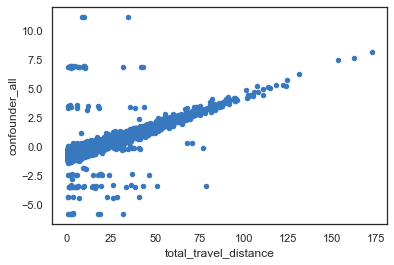

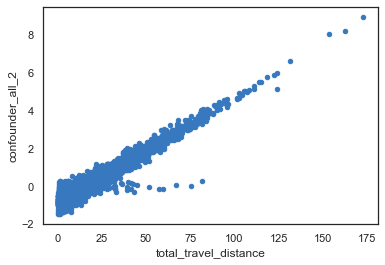

In [15]:
data_da = data[data['mode_id']==1]

data_da.plot.scatter('total_travel_distance', 'confounder_all')

data_da.plot.scatter('total_travel_distance', 'confounder_all_2')

## True Model

In [16]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="sim_choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")
mnl_model.get_statsmodels_summary()

/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Log-likelihood at zero: -15,176.6986
Initial Log-likelihood: -15,176.6986


/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -8,116.6614


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,976
Method:                                MLE   Df Model:                           24
Date:                     Sun, 07 Jun 2020   Pseudo R-squ.:                   0.465
Time:                             13:14:08   Pseudo R-bar-squ.:               0.464
AIC:                            16,281.323   Log-Likelihood:             -8,116.661
BIC:                            16,449.016   LL-Null:                   -15,176.699
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.4806      0.125    -11.831      0.000      -1.726      -1.235
ASC Shared Ride: 3+                                 -1.0591      0.135     -7.847      0.000      -1.324      -0.795
ASC Walk-Transit-Walk                                0.9292      0.131      7.078      0.000       0.672       1.186
ASC Drive-Transit-Walk                              -1.4083      0.145     -9.716      0.000      -1.692      -1.124
ASC Walk-Transit-Drive                              -1.6138      0.150    -10.788      0.000      -1.907      -1.321
ASC Walk                                             3.0480      0.135     22.606      0.000       2.784       3.312
ASC Bike                                             0.2714      0.103      2.627      0.009       0.069       0.474
Travel Time, units:min (Drive Alone)                -0.0844      0.005    -16.886      0.000      -0.094      -0.075
Travel Time, units:min (SharedRide-2)               -0.0903      0.006    -14.750      0.000      -0.102      -0.078
Travel Time, units:min (SharedRide-3+)              -0.1261      0.008    -16.050      0.000      -0.141      -0.111
Travel Time, units:min (All Transit Modes)          -0.0297      0.002    -19.750      0.000      -0.033      -0.027
Travel Cost, units:$ (Drive Alone)                  -0.2292      0.026     -8.744      0.000      -0.281      -0.178
Travel Cost, units:$ (SharedRide-2)                 -0.4378      0.057     -7.636      0.000      -0.550      -0.325
Travel Cost, units:$ (SharedRide-3+)                -0.7461      0.157     -4.749      0.000      -1.054      -0.438
Travel Cost, units:$ (All Transit Modes)            -0.1180      0.019     -6.316      0.000      -0.155      -0.081
Autos per licensed drivers (All Auto Modes)          1.3336      0.055     24.051      0.000       1.225       1.442
Travel Distance, units:mi (Drive Alone)              0.1056      0.009     11.880      0.000       0.088       0.123
Travel Distance, units:mi (SharedRide-2)             0.0637      0.011      5.689      0.000       0.042       0.086
Travel Distance, units:mi (SharedRide-3+)            0.0359      0.017      2.057      0.040       0.002       0.070
Travel Distance, units:mi (Walk)                    -1.0998      0.037    -30.075      0.000      -1.171      -1.028
Travel Distance, units:mi (Bike)                    -0.3209      0.016    -20.290      0.000      -0.352      -0.290
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.6706      0.123      5.459      0.000       0.430       0.911
Household Size (Shared Ride 2 & 3+)                  0.1142      0.022      5.194      0.000       0.071       0.157
Number of Kids in Household (Shared Ride 2 & 3+)     0.5737      0.026     21.827      0.000       0.522       0.625
=====================================

## Model 1

In [17]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification_noncausal = OrderedDict()
mnl_names_noncausal = OrderedDict()

mnl_specification_noncausal["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names_noncausal["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification_noncausal["total_travel_time"] = [1, 2, 3, [4, 5, 6]]
mnl_names_noncausal["total_travel_time"] = ['Travel Time, units:min (Drive Alone)',
                                  'Travel Time, units:min (SharedRide-2)',
                                  'Travel Time, units:min (SharedRide-3+)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification_noncausal["total_travel_cost"] = [1, 2, 3, [4, 5, 6]]
mnl_names_noncausal["total_travel_cost"] = ['Travel Cost, units:$ (Drive Alone)',
                                  'Travel Cost, units:$ (SharedRide-2)',
                                  'Travel Cost, units:$ (SharedRide-3+)',
                                  'Travel Cost, units:$ (All Transit Modes)']

mnl_specification_noncausal["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names_noncausal["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification_noncausal["cross_bay"] = [[2, 3]]
mnl_names_noncausal["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification_noncausal["household_size"] = [[2, 3]]
mnl_names_noncausal["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification_noncausal["num_kids"] = [[2, 3]]
mnl_names_noncausal["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

In [18]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_noncausal = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="sim_choice",
                                   specification=mnl_specification_noncausal,
                                   model_type="MNL",
                                   names=mnl_names_noncausal)

num_vars_noncausal = len(reduce(lambda x, y: x + y, mnl_names_noncausal.values()))
mnl_model_noncausal.fit_mle(np.zeros(num_vars_noncausal),
                  method="BFGS")

# Look at the estimation results
mnl_model_noncausal.get_statsmodels_summary()

/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Log-likelihood at zero: -15,176.6986
Initial Log-likelihood: -15,176.6986


/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -10,288.5691


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,981
Method:                                MLE   Df Model:                           19
Date:                     Sun, 07 Jun 2020   Pseudo R-squ.:                   0.322
Time:                             13:14:52   Pseudo R-bar-squ.:               0.321
AIC:                            20,615.138   Log-Likelihood:            -10,288.569
BIC:                            20,747.895   LL-Null:                   -15,176.699
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.1772      0.116    -10.187      0.000      -1.404      -0.951
ASC Shared Ride: 3+                                 -0.7079      0.126     -5.628      0.000      -0.954      -0.461
ASC Walk-Transit-Walk                                0.9579      0.122      7.877      0.000       0.720       1.196
ASC Drive-Transit-Walk                              -1.2297      0.138     -8.930      0.000      -1.500      -0.960
ASC Walk-Transit-Drive                              -1.4191      0.143     -9.955      0.000      -1.699      -1.140
ASC Walk                                            -1.0122      0.074    -13.670      0.000      -1.157      -0.867
ASC Bike                                            -1.2166      0.075    -16.141      0.000      -1.364      -1.069
Travel Time, units:min (Drive Alone)                -0.0386      0.003    -11.916      0.000      -0.045      -0.032
Travel Time, units:min (SharedRide-2)               -0.0623      0.004    -14.178      0.000      -0.071      -0.054
Travel Time, units:min (SharedRide-3+)              -0.1087      0.006    -16.983      0.000      -0.121      -0.096
Travel Time, units:min (All Transit Modes)          -0.0271      0.001    -19.033      0.000      -0.030      -0.024
Travel Cost, units:$ (Drive Alone)                  -0.0210      0.018     -1.138      0.255      -0.057       0.015
Travel Cost, units:$ (SharedRide-2)                 -0.2069      0.041     -4.996      0.000      -0.288      -0.126
Travel Cost, units:$ (SharedRide-3+)                -0.4500      0.100     -4.505      0.000      -0.646      -0.254
Travel Cost, units:$ (All Transit Modes)            -0.1086      0.018     -6.073      0.000      -0.144      -0.074
Autos per licensed drivers (All Auto Modes)          1.0899      0.050     22.013      0.000       0.993       1.187
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.6499      0.116      5.620      0.000       0.423       0.876
Household Size (Shared Ride 2 & 3+)                  0.0980      0.021      4.726      0.000       0.057       0.139
Number of Kids in Household (Shared Ride 2 & 3+)     0.5143      0.025     20.723      0.000       0.466       0.563
====================================================================================================================
"""

## Model 2

In [27]:
mnl_specification_causal_1 = mnl_specification_noncausal.copy()
mnl_names_causal_1 = mnl_names_noncausal.copy()

mnl_specification_causal_1["confounder_all"] = [1, 2, 3]
mnl_names_causal_1["confounder_all"] = ["Confounder - Drive alone",
                                     "Confounder - Shared ride 2", 
                                     "Confounder - Shared ride 3"]

In [28]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_causal_1 = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="sim_choice",
                                   specification=mnl_specification_causal_1,
                                   model_type="MNL",
                                   names=mnl_names_causal_1)

num_vars = len(reduce(lambda x, y: x + y, mnl_names_causal_1.values()))
mnl_model_causal_1.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model_causal_1.get_statsmodels_summary()

/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Log-likelihood at zero: -15,176.6986
Initial Log-likelihood: -15,176.6986


/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -10,286.6820


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,978
Method:                                MLE   Df Model:                           22
Date:                     Sun, 07 Jun 2020   Pseudo R-squ.:                   0.322
Time:                             13:19:48   Pseudo R-bar-squ.:               0.321
AIC:                            20,617.364   Log-Likelihood:            -10,286.682
BIC:                            20,771.082   LL-Null:                   -15,176.699
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.1424      0.130     -8.804      0.000      -1.397      -0.888
ASC Shared Ride: 3+                                 -0.6318      0.140     -4.517      0.000      -0.906      -0.358
ASC Walk-Transit-Walk                                1.0400      0.131      7.930      0.000       0.783       1.297
ASC Drive-Transit-Walk                              -1.1474      0.146     -7.847      0.000      -1.434      -0.861
ASC Walk-Transit-Drive                              -1.3369      0.151     -8.868      0.000      -1.632      -1.041
ASC Walk                                            -0.9296      0.089    -10.460      0.000      -1.104      -0.755
ASC Bike                                            -1.1341      0.090    -12.605      0.000      -1.310      -0.958
Travel Time, units:min (Drive Alone)                -0.0370      0.003    -10.969      0.000      -0.044      -0.030
Travel Time, units:min (SharedRide-2)               -0.0617      0.004    -13.880      0.000      -0.070      -0.053
Travel Time, units:min (SharedRide-3+)              -0.1090      0.006    -16.835      0.000      -0.122      -0.096
Travel Time, units:min (All Transit Modes)          -0.0271      0.001    -19.033      0.000      -0.030      -0.024
Travel Cost, units:$ (Drive Alone)                  -0.0127      0.019     -0.664      0.507      -0.050       0.025
Travel Cost, units:$ (SharedRide-2)                 -0.1992      0.042     -4.709      0.000      -0.282      -0.116
Travel Cost, units:$ (SharedRide-3+)                -0.4524      0.101     -4.490      0.000      -0.650      -0.255
Travel Cost, units:$ (All Transit Modes)            -0.1086      0.018     -6.069      0.000      -0.144      -0.073
Autos per licensed drivers (All Auto Modes)          1.0979      0.050     22.022      0.000       1.000       1.196
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.6717      0.118      5.697      0.000       0.441       0.903
Household Size (Shared Ride 2 & 3+)                  0.0986      0.021      4.750      0.000       0.058       0.139
Number of Kids in Household (Shared Ride 2 & 3+)     0.5169      0.025     20.711      0.000       0.468       0.566
Confounder - Drive alone                            -0.0782      0.046     -1.686      0.092      -0.169       0.013
Confounder - Shared ride 2                          -0.0402      0.044     -0.911      0.362      -0.127       0.046
Confounder - Shared ride 3                           0.0084      0.048      0.175      0.861      -0.086       0.102
====================================================================================================================
"""

## Model 3

In [29]:
mnl_specification_causal_2 = mnl_specification_noncausal.copy()
mnl_names_causal_2 = mnl_names_noncausal.copy()

mnl_specification_causal_2["confounder_all_2"] = [1, 2, 3]
mnl_names_causal_2["confounder_all_2"] = ["Confounder - Drive alone",
                                     "Confounder - Shared ride 2", 
                                     "Confounder - Shared ride 3"]

In [30]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_causal_2 = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="sim_choice",
                                   specification=mnl_specification_causal_2,
                                   model_type="MNL",
                                   names=mnl_names_causal_2)

num_vars = len(reduce(lambda x, y: x + y, mnl_names_causal_2.values()))
mnl_model_causal_2.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model_causal_2.get_statsmodels_summary()

/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Log-likelihood at zero: -15,176.6986
Initial Log-likelihood: -15,176.6986


/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -10,287.9297


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,978
Method:                                MLE   Df Model:                           22
Date:                     Sun, 07 Jun 2020   Pseudo R-squ.:                   0.322
Time:                             13:20:35   Pseudo R-bar-squ.:               0.321
AIC:                            20,619.859   Log-Likelihood:            -10,287.930
BIC:                            20,773.578   LL-Null:                   -15,176.699
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.3058      0.317     -4.121      0.000      -1.927      -0.685
ASC Shared Ride: 3+                                 -1.1021      0.383     -2.878      0.004      -1.853      -0.352
ASC Walk-Transit-Walk                                0.8831      0.218      4.054      0.000       0.456       1.310
ASC Drive-Transit-Walk                              -1.3045      0.227     -5.743      0.000      -1.750      -0.859
ASC Walk-Transit-Drive                              -1.4937      0.230     -6.494      0.000      -1.945      -1.043
ASC Walk                                            -1.0874      0.195     -5.568      0.000      -1.470      -0.705
ASC Bike                                            -1.2918      0.196     -6.595      0.000      -1.676      -0.908
Travel Time, units:min (Drive Alone)                -0.0402      0.005     -8.169      0.000      -0.050      -0.031
Travel Time, units:min (SharedRide-2)               -0.0612      0.007     -9.181      0.000      -0.074      -0.048
Travel Time, units:min (SharedRide-3+)              -0.1016      0.009    -10.755      0.000      -0.120      -0.083
Travel Time, units:min (All Transit Modes)          -0.0271      0.001    -19.035      0.000      -0.030      -0.024
Travel Cost, units:$ (Drive Alone)                  -0.0300      0.028     -1.056      0.291      -0.086       0.026
Travel Cost, units:$ (SharedRide-2)                 -0.1961      0.063     -3.101      0.002      -0.320      -0.072
Travel Cost, units:$ (SharedRide-3+)                -0.3560      0.136     -2.617      0.009      -0.623      -0.089
Travel Cost, units:$ (All Transit Modes)            -0.1087      0.018     -6.075      0.000      -0.144      -0.074
Autos per licensed drivers (All Auto Modes)          1.0898      0.050     22.009      0.000       0.993       1.187
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.6489      0.116      5.611      0.000       0.422       0.876
Household Size (Shared Ride 2 & 3+)                  0.0980      0.021      4.727      0.000       0.057       0.139
Number of Kids in Household (Shared Ride 2 & 3+)     0.5144      0.025     20.729      0.000       0.466       0.563
Confounder - Drive alone                             0.0739      0.177      0.417      0.676      -0.273       0.421
Confounder - Shared ride 2                          -0.0503      0.218     -0.230      0.818      -0.478       0.378
Confounder - Shared ride 3                          -0.2952      0.290     -1.019      0.308      -0.863       0.272
====================================================================================================================
"""

## Compare estimates on travel time and cost

In [58]:
results_summary_true = mnl_model.get_statsmodels_summary()
results_summary_non_causal = mnl_model_noncausal.get_statsmodels_summary()
results_summary_method_1 = mnl_model_causal_1.get_statsmodels_summary()
results_summary_method_2 = mnl_model_causal_2.get_statsmodels_summary()

results_as_html_true = results_summary_true.tables[1].as_html()
results_as_html_true = pd.read_html(results_as_html_true, header=0, index_col=0)[0]

results_as_html_noncausal = results_summary_non_causal.tables[1].as_html()
results_as_html_noncausal = pd.read_html(results_as_html_noncausal, header=0, index_col=0)[0]

results_as_html_method_1 = results_summary_method_1.tables[1].as_html()
results_as_html_method_1 = pd.read_html(results_as_html_method_1, header=0, index_col=0)[0]

results_as_html_method_2 = results_summary_method_2.tables[1].as_html()
results_as_html_method_2 = pd.read_html(results_as_html_method_2, header=0, index_col=0)[0]

In [60]:
locs = ['Travel Time, units:min (Drive Alone)','Travel Time, units:min (SharedRide-2)',
       'Travel Time, units:min (SharedRide-3+)', 'Travel Cost, units:$ (Drive Alone)',
       'Travel Cost, units:$ (SharedRide-2)', 'Travel Cost, units:$ (SharedRide-3+)']
cols = ['coef', 'std err']

results_comparison = results_as_html_true.loc[locs][cols].join(results_as_html_noncausal.loc[locs][cols], 
                                                               lsuffix = '_true', rsuffix = '_non_causal').join(
    results_as_html_method_1.loc[locs][cols].join(results_as_html_method_2.loc[locs][cols],
                                               lsuffix = '_method_1', rsuffix = '_method_2'))

results_comparison

,coef_true,std err_true,coef_non_causal,std err_non_causal,coef_method_1,std err_method_1,coef_method_2,std err_method_2
"Travel Time, units:min (Drive Alone)",-0.0844,0.005,-0.0386,0.003,-0.0370,0.003,-0.0402,0.005
"Travel Time, units:min (SharedRide-2)",-0.0903,0.006,-0.0623,0.004,-0.0617,0.004,-0.0612,0.007
"Travel Time, units:min (SharedRide-3+)",-0.1261,0.008,-0.1087,0.006,-0.1090,0.006,-0.1016,0.009
"Travel Cost, units:$ (Drive Alone)",-0.2292,0.026,-0.0210,0.018,-0.0127,0.019,-0.0300,0.028
"Travel Cost, units:$ (SharedRide-2)",-0.4378,0.057,-0.2069,0.041,-0.1992,0.042,-0.1961,0.063
"Travel Cost, units:$ (SharedRide-3+)",-0.7461,0.157,-0.4500,0.100,-0.4524,0.101,-0.3560,0.136
